# Tappy Keystroke Data with Parkinson’s Patients

Tappy è un'applicazione per la registrazione delle sequenze di battitura.

Nel progetto verrà analizzato un dataset contenente i registri delle sequenze di tasti raccolti da oltre 200 soggetti, con e senza il morbo di Parkinson, che hanno digitato normalmente sul proprio computer per un periodo di settimane o mesi, senza supervisione.

L'analisi si compone di una parte di acquisizione e pulizia dei dati, e di un'altra parte per l'utilizzo di modelli di machine learning, che hanno lo scopo di indicare che l'interazione con la tastiera può essere usata per rilevare particolarità nel movimento delle dita nelle prime fasi del morbo di Parkinson.

Il dataset è stato scaricato dal link https://www.kaggle.com/datasets/valkling/tappy-keystroke-data-with-parkinsons-patients. È suddiviso a sua volta in due dataset: il primo è fornito direttamente dal software Tappy, quindi include dati come tempo di pressione e rilascio dei tasti e movimenti ottenuti dividendo virtualmente la tastiera in una zona di destra e una di sinistra; il secondo contiene informazioni sui pazienti (quali anno di nascita, sesso, e attributi riguardanti il morbo di Parkinson qualora il paziente ne fosse affetto). Tra questi, l'attributo più importante è "Parkinsons", che verrà usata come predizione per la classificazione binaria.

Al dataset è associato un articolo preso dal sito https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188226#sec008, in cui viene spiegato il significato degli attributi. Da questo paper abbiamo tratto informazioni utili per l'acquisizione dei dati.

## Indice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
#from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

## Caricamento dataset

In [2]:
# Creation of user_df, a DataFrame with informations about Archived Users

users = []

for filepath in glob.iglob('Users/Archived users/*.txt'):
    users.append(filepath[-14:-4])

user_number = len(users)    # number of users

user_df = pd.DataFrame(users, columns = ["Users"])

# Create columns

col_index = []

file = open('Users/Archived users/User_' + str(users[0]) + ".txt")
lines = file.read().split("\n")
ll = len(lines)

for l in range(ll-1):
    sl = lines[l].split(": ", 1)
    col_index.append(sl[0])

# Create values

values_list = []
values = []

for i in range(user_number):
    file = open('Users/Archived users/User_' + str(users[i]) + ".txt")
    lines = file.read().split("\n")
    for l in range(ll-1):
        sl = lines[l].split(": ", 1)
        v = sl[1]
        values.append(v)
    values_list.append(values)
    values = []

# Insert values in user_df

value_df = pd.DataFrame(values_list, columns = col_index)

user_df = pd.concat([user_df, value_df], axis = 1)

# Creation of tappydata_df, a DataFrame with informations about Archived Data

tappydata = []

for filepath in glob.iglob('Data/Tappy Data/*.txt'):
    file = open(filepath)
    lines = file.read().split("\n")
    for l in range(len(lines)-1):
        x = lines[l]
        x = x.split("\t")
        tappydata.append(x)

tappydata_df = pd.DataFrame(tappydata, columns = ["Users", "Date", "Datetime", "TapPosition", "Hold", "Movement", "Latency", "Flight", "*"])

# Merge user_df with tappydata_df, joining on the attribute "Users"

all_userdata_df = pd.merge(tappydata_df, user_df, how='inner', left_on='Users', right_on='Users')

In [26]:
all_userdata_df.head(10)

,Users,Date,Datetime,TapPosition,Hold,Movement,Latency,Flight,*,BirthYear,...,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
0,0EA27ICBLF,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
1,0EA27ICBLF,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
2,0EA27ICBLF,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
3,0EA27ICBLF,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
4,0EA27ICBLF,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
5,0EA27ICBLF,160722,18:42:15.766,L,0078.1,SL,0226.6,0101.6,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
6,0EA27ICBLF,160722,18:42:15.969,R,0085.9,LR,0195.3,0117.2,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
7,0EA27ICBLF,160722,18:42:16.875,R,0085.9,RR,0359.4,0296.9,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
8,0EA27ICBLF,160722,18:42:17.289,L,0070.3,RL,0429.7,0343.8,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
9,0EA27ICBLF,160722,18:42:17.727,L,0101.6,LL,0406.3,0335.9,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False


## Pulizia dataset

Tra i pazienti con il morbo di Parkinson consideriamo solo quelli nelle prime fasi della malattia. Per questo si mantengono solo i pazienti con impatto lieve, oltre a quelli non malati.

Sempre facendo fede all'articolo di riferimento, sono stati eliminati dall'analisi anche i pazienti che assumevano Levadopa.

Inoltre sono stati rimossi i pazienti di cui sono stati analizzati troppi o troppi pochi dati, con lo scopo di avere un insieme di dati più consistente e bilanciato.

Dopo la pulizia di questi attributi, sono state cancellate le colonne ritenute meno utili per l'addestramento.

Infine si prendono in esame solo gli utenti di cui si conosce l'anno di nascita, poiché l'età è un attributo determinante e fortemente correlato alla positività al morbo di Parkinson.

In [3]:
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Severe"]
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Medium"]

all_userdata_df = all_userdata_df[all_userdata_df.Levadopa == "False"]

counts = all_userdata_df['Users'].value_counts()
#avg = all_userdata_df.shape[0] / len(counts)
#print(avg)  # numero medio di tap per ogni utente

all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts > 1000].index)]
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts < 100000].index)]

#all_userdata_df = all_userdata_df.drop(["Date", "Datetime", "Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)
all_userdata_df = all_userdata_df.drop(["Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)

all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['BirthYear']==''].index, inplace=True)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in termini di eta

In [5]:
all_userdata_df.head(10)
#all_userdata_df.info()

,Users,Date,Datetime,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,160916,19:20:43.891,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,160916,19:20:44.344,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,160916,19:20:44.742,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,160916,19:20:45.516,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,160916,19:20:46.047,R,101.6,LR,523.4,58,0,0
158458,0QAZFRHQHW,160916,19:20:46.242,R,93.8,RR,203.1,58,0,0
158459,0QAZFRHQHW,160918,10:35:01.508,L,109.4,RL,289.1,58,0,0
158460,0QAZFRHQHW,160918,10:35:01.930,R,214.8,LR,316.4,58,0,0
158461,0QAZFRHQHW,160918,10:35:02.164,R,66.4,RR,382.8,58,0,0
158462,0QAZFRHQHW,160918,10:44:58.918,L,93.8,RL,562.5,58,0,0


In [4]:
from datetime import datetime

all_userdata_df.Date = all_userdata_df.Date.astype(str)
all_userdata_df.Datetime = all_userdata_df.Datetime.astype(str)
#all_userdata_df.head(10)

array_app = []

for i in range(len(all_userdata_df)):

    elem = all_userdata_df.iloc[i].Datetime[0:8]
    elem1 =all_userdata_df.iloc[i].Date
    elem_time = datetime.strptime(elem1+" " +elem, '%d%m%y %H:%M:%S')
    array_app.append(elem_time)

In [5]:

pipo = pd.DataFrame(array_app,columns=['Date'])
pipo.head()

,Date
0,2016-09-16 19:20:43
1,2016-09-16 19:20:44
2,2016-09-16 19:20:44
3,2016-09-16 19:20:45
4,2016-09-16 19:20:46


In [6]:
all_userdata_df = all_userdata_df.drop(columns=["Date","Datetime"])
all_userdata_df_v2 = pd.concat([all_userdata_df, pipo], axis=1)

all_userdata_df_v2.head(10)

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons,Date
158453,0QAZFRHQHW,L,0078.1,LL,0312.5,58.0,Female,False,2021-07-16 08:53:25
158454,0QAZFRHQHW,L,0078.1,LL,0453.1,58.0,Female,False,2021-07-16 08:53:33
158455,0QAZFRHQHW,L,0062.5,LL,0414.1,58.0,Female,False,2021-07-16 08:53:33
158456,0QAZFRHQHW,L,0093.8,LL,0742.2,58.0,Female,False,2021-07-16 08:53:33
158457,0QAZFRHQHW,R,0101.6,LR,0523.4,58.0,Female,False,2021-07-16 08:53:35
158458,0QAZFRHQHW,R,0093.8,RR,0203.1,58.0,Female,False,2021-07-16 08:53:35
158459,0QAZFRHQHW,L,0109.4,RL,0289.1,58.0,Female,False,2021-07-16 08:53:36
158460,0QAZFRHQHW,R,0214.8,LR,0316.4,58.0,Female,False,2021-07-16 08:53:36
158461,0QAZFRHQHW,R,0066.4,RR,0382.8,58.0,Female,False,2021-07-16 08:53:36
158462,0QAZFRHQHW,L,0093.8,RL,0562.5,58.0,Female,False,2021-07-16 08:53:36


In [7]:
#all_userdata_df.Age = all_userdata_df.Age.astype(str)
#all_userdata_df.Gender = all_userdata_df.Gender.astype(str)
#all_userdata_df_v2.info()

#all_userdata_df_v2.Age = all_userdata_df_v2.Age.astype(int)
all_userdata_df_v2.Hold = all_userdata_df_v2.Hold.astype(float)

all_userdata_df_v2.Latency = all_userdata_df_v2.Latency.astype(float)

all_userdata_df_v2.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df_v2.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)
all_userdata_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990206 entries, 158453 to 1055474
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Users        object        
 1   TapPosition  object        
 2   Hold         float64       
 3   Movement     object        
 4   Latency      float64       
 5   Age          float64       
 6   Gender       float64       
 7   Parkinsons   float64       
 8   Date         datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 151.8+ MB


In [12]:
all_userdata_df_v2.head()
all_userdata_df_v2.iloc[0:2,1]

158453    L
158454    L
Name: TapPosition, dtype: object

In [94]:
cazzo = all_userdata_df_v2.iloc[0:1,:]
#print(cazzo)
a =cazzo.values.tolist()
print((a))
print(a[0])



[['0QAZFRHQHW', 'L', 78.1, 'LL', 312.5, 58.0, 0.0, 0.0, Timestamp('2021-07-16 08:53:25')]]
['0QAZFRHQHW', 'L', 78.1, 'LL', 312.5, 58.0, 0.0, 0.0, Timestamp('2021-07-16 08:53:25')]


In [8]:
"""
x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values
"""

g = len(all_userdata_df)
current_user = all_userdata_df_v2.iloc[0,0]         #parto dalla prima posizione
#print(current_user)
list_users = all_userdata_df_v2.Users.unique()
len_lu =len(list_users) #ultimo elemento di list_users è nan

data_list = []

for j in range(len_lu-1):
    #print(j)
    set = all_userdata_df_v2[all_userdata_df_v2['Users'] == list_users[j]]      #sottodataframe con righe corrispondenti allo user j
    rif_row = set.iloc[0,:]                 #prima riga dell'utente j
    ind_row = 0                             #indice di riga di riferimento dell'utente j
    #print(rif_row[-1])

    for k in range(len(set)):               #scorro righe dell'utente j
        current_row = set.iloc[k,:]
        time2 = current_row[-1]             #data (ultima colonna) della riga corrente
        time1 = rif_row[-1]
        diff_time = (time2 - time1).total_seconds()
        #print(diff_time)

        if(diff_time >= 90):  # or sulla fine delle digit ??
        # k mi da numero di digit nella serie, se volessi avere un num min metto controllo
            mini_df = set.iloc[ind_row:k-1,:]
            #mini_df.head()
            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  
            # QUA DEVO CALCOLARE MEDIA E VAR ECC DELLA SERIA DI DIGIT -> fare come altra versione per le medie ecc
            
            hold_by_user =  mini_df[mini_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
            hold_by_user_flat = hold_by_user.unstack()
            hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
            #hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']

            latency_by_user = mini_df[np.isin(mini_df['Movement'], ['LL', 'LR', 'RL', 'RR'])].groupby(['Users', 'Movement'])['Latency'].agg([np.mean, np.std, skew, kurtosis])
            latency_by_user_flat = latency_by_user.unstack()
            latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
            #latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
            #latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']

            combined_df = pd.concat([hold_by_user_flat, latency_by_user_flat], axis = 1)

            if (len(combined_df.values) != 0 ):
                #data_list.append(combined_df.values.tolist()[0])
                data_list.append(combined_df.reset_index(level=0).values.tolist()[0])

            # hold_by_user =  all_userdata_df[all_userdata_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
            # da sistemare

            # inserire questa riga in un nuovo dataframe o lista su cui poi faccio database

            # fare lo stesso con latenze RL LR ecc..

            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            ind_row = k
            rif_row = set.iloc[ind_row,:]
            # attenzione con questo > 90 potrei buttare ultima time serie 
    


print(len(data_list))

c:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1107: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1216: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1107: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: inval

1106


,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR
0,6LB9FQABZQ,118.860185,98.468254,67.292876,52.216722,-0.09952,0.002544,-1.247375,-1.019151,177.932258,...,121.194238,108.463661,1.804871,1.785562,4.303976,2.233831,4.310818,2.082781,20.580164,5.52687


In [10]:
column_names = ['Users','mean_L','mean_R','std_L','std_R','skew_L','skew_R','kurtosis_L','kurtosis_R','mean_LL','mean_LR','mean_RL','mean_RR','std_LL','std_LR','std_RL','std_RR','skew_LL','skew_LR','skew_RL','skew_RR','kustosis_LL','kurtosis_LR','kurtosis_RL','kurtosis_RR']
#print(data_list[0:10])

pandino = pd.DataFrame(data_list, columns = column_names)
pandino.head(10)
#pandino.shape

pan = pandino.fillna(0)
pan.head(10)


,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR
0,0QAZFRHQHW,96.964384,108.926667,26.595939,34.064793,-0.560029,7.945787e-01,0.995035,0.889816,403.148718,...,1.840861e+02,129.402258,0.255349,-1.104453e-01,1.203995,1.500930e-01,-0.555807,-1.364565,0.595170,-0.638379
1,0QAZFRHQHW,80.530769,86.254167,18.025577,13.496472,-0.919233,4.432484e-01,0.723541,-0.745270,334.271429,...,8.715406e+01,161.895361,0.665274,1.860274e-01,0.152461,1.184368e+00,-0.885243,-1.262511,-0.341977,0.436949
2,0QAZFRHQHW,90.331034,91.764706,18.893233,15.452027,1.446305,-2.726574e-01,3.447201,-0.670671,344.866667,...,1.429313e+02,134.344323,0.907895,1.113669e+00,0.857548,-8.299642e-02,0.282873,0.797022,0.336018,-0.941498
3,0QAZFRHQHW,93.800000,89.850000,0.000000,11.101576,0.000000,2.761462e-15,-3.000000,-2.000000,714.800000,...,0.000000e+00,0.000000,0.000000,-3.000000e+00,-3.000000,-3.000000e+00,0.000000,0.000000,0.000000,0.000000
4,0QAZFRHQHW,102.300000,106.450000,16.600442,30.613769,-0.169375,4.657946e-01,-1.143875,-1.149358,270.411111,...,1.454514e+02,159.615862,-0.150172,3.523632e-01,-0.173451,6.839070e-01,-1.215306,-1.500000,-1.701365,-1.500000
5,0QAZFRHQHW,101.580000,94.540000,14.622190,4.327008,0.182403,-4.082483e-01,-1.059759,-1.833333,177.750000,...,0.000000e+00,0.471681,0.295749,-2.000000e+00,-1.318944,-1.598969e+00,0.000000,0.000000,0.000000,0.000000
6,0QAZFRHQHW,112.510000,92.022222,18.471807,11.597821,0.831131,3.042344e-01,0.130672,-0.448776,401.066667,...,2.680916e+02,91.278842,0.673886,6.515194e-16,0.336345,-3.486609e-01,-1.500000,-2.000000,-1.428411,-0.847771
7,0QAZFRHQHW,95.310000,92.800000,22.947159,15.768957,-0.229808,-8.500522e-01,-0.866814,-0.927701,356.260000,...,0.000000e+00,129.824805,1.110868,2.788014e-15,0.000000,-8.276463e-16,-0.228322,-2.000000,-3.000000,-2.000000
8,0QAZFRHQHW,85.385714,89.800000,12.671678,0.000000,0.043681,0.000000e+00,-1.640805,-3.000000,501.950000,...,-5.241212e-16,0.000000,-0.702417,-2.000000e+00,-3.000000,-1.500000e+00,0.000000,0.000000,0.000000,0.000000
9,0QAZFRHQHW,93.116667,86.583333,31.865242,14.300548,-1.108628,4.475948e-01,-0.176721,-0.887627,562.500000,...,1.426470e+02,0.000000,0.000000,6.503676e-01,-0.184777,0.000000e+00,-3.000000,-1.500000,-1.543166,-3.000000


In [113]:
pan.isna().sum()

Users          0
mean_L         0
mean_R         0
std_L          0
std_R          0
skew_L         0
skew_R         0
kurtosis_L     0
kurtosis_R     0
mean_LL        0
mean_LR        0
mean_RL        0
mean_RR        0
std_LL         0
std_LR         0
std_RL         0
std_RR         0
skew_LL        0
skew_LR        0
skew_RL        0
skew_RR        0
kustosis_LL    0
kurtosis_LR    0
kurtosis_RL    0
kurtosis_RR    0
dtype: int64

(array([28.,  8.,  2.,  2.,  6.,  2.,  3.,  2.,  0.,  1.]),
 array([  1000.,  10900.,  20800.,  30700.,  40600.,  50500.,  60400.,
         70300.,  80200.,  90100., 100000.]),
 <BarContainer object of 10 artists>)

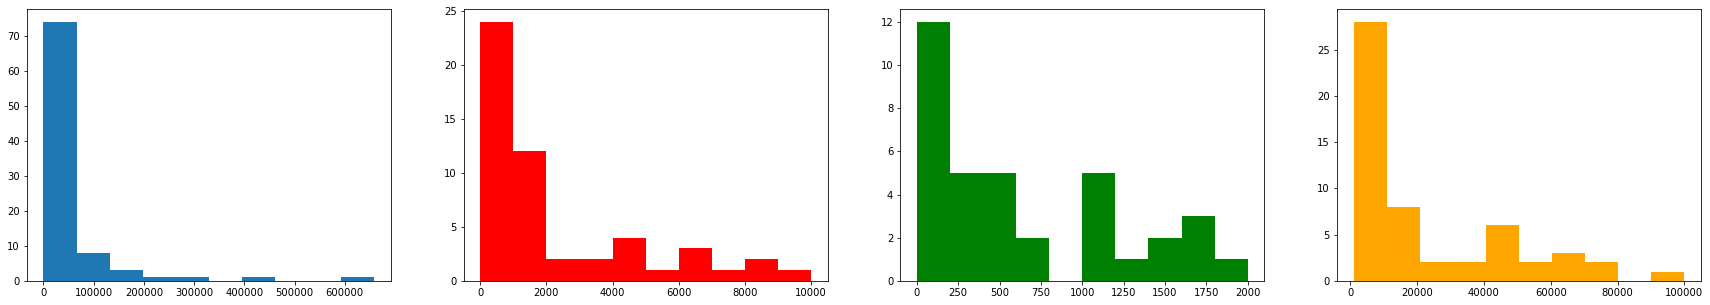

In [41]:
fig, axs = plt.subplots(1, 4, figsize = (30,5))
axs[0].hist(counts)
axs[1].hist(counts, range = [0, 10000], color = "red")
axs[2].hist(counts, range = [0, 2000], color = "green")
axs[3].hist(counts, range = [1000, 100000], color = "orange") # area of interest

In [33]:
# counts = all_userdata_df['Users'].value_counts()

# counts_parkinson = all_userdata_df[all_userdata_df["Parkinsons"] == "True"]
# counts_parkinsonf = all_userdata_df[all_userdata_df["Parkinsons"] == "False"]

# counts_parkinson.nunique()
# counts_parkinsonf.nunique()
# print(len(counts))
#siamo 48, 18 positivi 30 negativi

In [33]:
# all_userdata_df.info()


all_userdata_df.Hold = all_userdata_df.Hold.astype(float)

all_userdata_df.Latency = all_userdata_df.Latency.astype(float)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in termini di eta

all_userdata_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)


In [18]:
all_userdata_df.head()


,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0


In [26]:
print(all_userdata_df["Hold"])

158453      78.1
158454      78.1
158455      62.5
158456      93.8
158457     101.6
           ...  
8663133    109.4
8663134    125.0
8663135    171.9
8663136    132.8
8663137    109.4
Name: Hold, Length: 1055475, dtype: float64


In [5]:
# questo non lho fatto
hold_z_scores = stats.zscore(all_userdata_df["Hold"])
abs_z_scores = np.abs(hold_z_scores)

filtered_entries = (abs_z_scores < 3)

all_userdata_df = all_userdata_df[filtered_entries]

#################

lat_z_scores = stats.zscore(all_userdata_df["Latency"])
abs_z_scores = np.abs(lat_z_scores)

filtered_entries2 = (abs_z_scores < 3)

all_latencyfiall_userdata_dfltered = all_userdata_df[filtered_entries2]

#################

all_userdata_df.head(10)

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0
158458,0QAZFRHQHW,R,93.8,RR,203.1,58,0,0
158459,0QAZFRHQHW,L,109.4,RL,289.1,58,0,0
158460,0QAZFRHQHW,R,214.8,LR,316.4,58,0,0
158461,0QAZFRHQHW,R,66.4,RR,382.8,58,0,0
158462,0QAZFRHQHW,L,93.8,RL,562.5,58,0,0


In [6]:
# all_userdata_df.head()

# tappostion -> hold
# movement -> latency
hold_by_user =  all_userdata_df[all_userdata_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
hold_by_user.head(10)

mean        std      skew    kurtosis
Users      TapPosition                                             
0QAZFRHQHW L             98.931818  23.869914  0.236277    0.843128
           R            101.595749  37.219557  7.474979  109.926842
1XNJCXS3EY L            153.702407  53.213749  0.264109    0.605739
           R            105.622423  27.036622  2.790381   23.913747
3DIXPRIOSW L            147.626087  47.259923  0.665327    0.592999
           R            167.039039  56.045862  0.260479    0.476607
48DZPAJ5NS L            125.093648  21.344768  0.433347    5.116874
           R            125.944823  20.440962  0.122130    5.692705
5PQVTWULAC L            131.724002  37.064749  0.978465    7.127388
           R            113.398834  29.041533 -0.062599    0.907739

In [7]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']
hold_by_user_flat.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff
Users,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168


In [8]:
latency_by_user = all_userdata_df[np.isin(all_userdata_df['Movement'], ['LL', 'LR', 'RL', 'RR'])].groupby(['Users', 'Movement'])['Latency'].agg([np.mean, np.std, skew, kurtosis])
latency_by_user.head(10)

mean         std      skew  kurtosis
Users      Movement                                            
0QAZFRHQHW LL        406.716242  162.606085  0.375895 -0.521971
           LR        411.718182  196.200749  0.247982 -1.102464
           RL        430.258974  178.154385  0.282171 -0.923822
           RR        365.736471  155.345904  0.572132 -0.265011
1XNJCXS3EY LL        347.882547  101.977747 -1.332784  1.946994
           LR        313.541489   97.680669  0.008248 -0.715397
           RL        310.799454   98.038127  0.037478 -0.723288
           RR        322.170833   82.901327 -0.284840  0.725222
3DIXPRIOSW LL        528.670445  137.542548 -0.192664 -0.096967
           LR        575.478761  148.448891 -0.259537 -1.163198

In [9]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']
latency_by_user_flat.head()

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
Users,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,406.716242,411.718182,430.258974,365.736471,162.606085,196.200749,178.154385,155.345904,0.375895,0.247982,0.282171,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771
1XNJCXS3EY,347.882547,313.541489,310.799454,322.170833,101.977747,97.680669,98.038127,82.901327,-1.332784,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714
3DIXPRIOSW,528.670445,575.478761,501.274093,493.779630,137.542548,148.448891,143.404457,163.597901,-0.192664,-0.259537,0.357609,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816
48DZPAJ5NS,300.190663,335.274126,321.053098,332.504906,81.809939,81.450453,88.512695,90.989458,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242
5PQVTWULAC,358.358252,478.761804,454.325847,383.152730,121.124398,128.429826,135.090148,137.104995,0.928077,-0.016904,0.386154,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478


In [10]:
combined_df = pd.concat([hold_by_user_flat, latency_by_user_flat], axis = 1)
combined_df.shape

(48, 27)

In [11]:
combined_df.head(10)

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930,406.716242,...,0.375895,0.247982,0.282171,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-1.332784,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952,528.670445,...,-0.192664,-0.259537,0.357609,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168,358.358252,...,0.928077,-0.016904,0.386154,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228,177.817371,...,1.835981,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207,-5.769697,1.055860
6LB9FQABZQ,126.497906,98.528074,66.799577,48.545522,0.268232,0.054373,0.026491,0.673011,27.969833,189.123008,...,1.877934,1.850307,2.629422,2.052090,4.015846,3.173508,8.035135,5.091122,36.452778,2.387666
8O9IAIA9L1,86.372264,98.035971,32.266916,36.803377,0.926908,0.713697,2.932109,2.254495,-11.663708,217.950469,...,2.194407,2.198037,2.210455,2.046020,7.687335,5.906320,7.503160,5.253490,4.570861,2.363081
9RCEHVGNCJ,122.474658,121.237843,67.000131,31.916202,-0.091724,-0.705349,-0.823919,1.681515,1.236814,278.909500,...,0.805929,1.965561,1.715084,1.152110,0.837801,4.142594,4.491134,1.826083,-23.957022,-10.160714


In [11]:
all_userdata_df = all_userdata_df.drop(["TapPosition", "Hold", "Latency", "Movement"], axis=1)
all_userdata_df = all_userdata_df.drop_duplicates()

In [12]:
# combined_df.set_index('Users', inplace = True)

# complete_df = combined_df.merge(all_userdata_df[["Users", "Age", "Gender", "Parkinsons"]], how="left", on=["Users"], indicator = True)
# combined_df.set_index('Users', inplace = True)
# all_userdata_df.set_index('Users', inplace = True)
#complete_df = pd.merge(combined_df, all_userdata_df_dropped, how='left', left_on = 'Users', right_on = 'Users')
# complete_df.shape
#complete_df.head(10)

#complete_df = combined_df.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df = pan.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df.head()

,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,Age,Gender,Parkinsons
0,0QAZFRHQHW,96.964384,108.926667,26.595939,34.064793,-0.560029,7.945787e-01,0.995035,0.889816,403.148718,...,-0.110445,1.203995,0.150093,-0.555807,-1.364565,0.595170,-0.638379,58,Female,False
1,0QAZFRHQHW,80.530769,86.254167,18.025577,13.496472,-0.919233,4.432484e-01,0.723541,-0.745270,334.271429,...,0.186027,0.152461,1.184368,-0.885243,-1.262511,-0.341977,0.436949,58,Female,False
2,0QAZFRHQHW,90.331034,91.764706,18.893233,15.452027,1.446305,-2.726574e-01,3.447201,-0.670671,344.866667,...,1.113669,0.857548,-0.082996,0.282873,0.797022,0.336018,-0.941498,58,Female,False
3,0QAZFRHQHW,93.800000,89.850000,0.000000,11.101576,0.000000,2.761462e-15,-3.000000,-2.000000,714.800000,...,-3.000000,-3.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,58,Female,False
4,0QAZFRHQHW,102.300000,106.450000,16.600442,30.613769,-0.169375,4.657946e-01,-1.143875,-1.149358,270.411111,...,0.352363,-0.173451,0.683907,-1.215306,-1.500000,-1.701365,-1.500000,58,Female,False


In [23]:
complete_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)
complete_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)
complete_df= complete_df.drop(['Users'],axis = 1)
complete_df.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,mean_LR,...,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,Age,Gender,Parkinsons
0,96.964384,108.926667,26.595939,34.064793,-0.560029,7.945787e-01,0.995035,0.889816,403.148718,351.190625,...,-0.110445,1.203995,0.150093,-0.555807,-1.364565,0.595170,-0.638379,58,0,0
1,80.530769,86.254167,18.025577,13.496472,-0.919233,4.432484e-01,0.723541,-0.745270,334.271429,242.191667,...,0.186027,0.152461,1.184368,-0.885243,-1.262511,-0.341977,0.436949,58,0,0
2,90.331034,91.764706,18.893233,15.452027,1.446305,-2.726574e-01,3.447201,-0.670671,344.866667,308.146154,...,1.113669,0.857548,-0.082996,0.282873,0.797022,0.336018,-0.941498,58,0,0
3,93.800000,89.850000,0.000000,11.101576,0.000000,2.761462e-15,-3.000000,-2.000000,714.800000,375.000000,...,-3.000000,-3.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,58,0,0
4,102.300000,106.450000,16.600442,30.613769,-0.169375,4.657946e-01,-1.143875,-1.149358,270.411111,408.866667,...,0.352363,-0.173451,0.683907,-1.215306,-1.500000,-1.701365,-1.500000,58,0,0


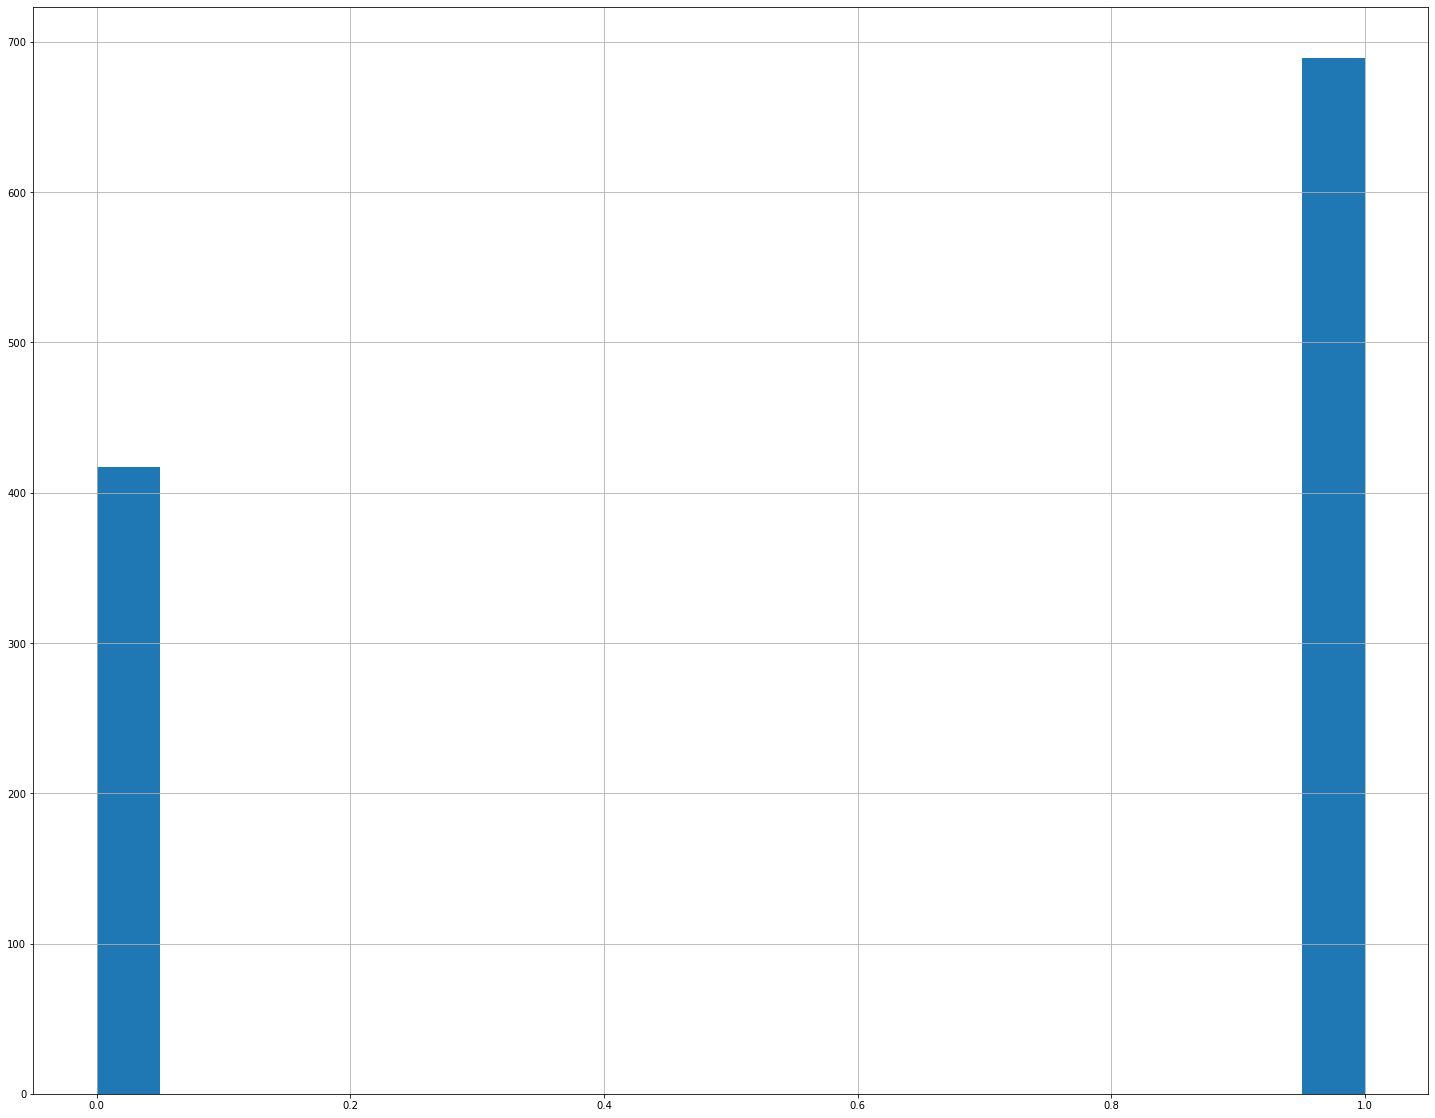

In [21]:
complete_df.Parkinsons.hist(bins=20, figsize=(25, 20))
plt.show()


In [42]:
# le colonne ora sono: tap position (L/R), Hold, Movement, BirthYear, Gender, Parkinsons (T/F)
# rimuovo gli utenti senza data di nascita, perche mi serve per calcolare l'eta


# normalizzazione
# L/R - Gender - Parkinson : devono diventare campi binari del tipo 0/1
# movement : lo codifichiamo con onehot dividendolo in 4 colonne
# latency - hold : sono dei float
# age (ottenuta da 2017 - birthyear) : int


# all_userdata_df.TapPosition.replace(['R', 'L', 'S'], [0, 1, 2], inplace = True)

# all_userdata_df.Movement.replace(['LL', 'LR', 'RR', 'RL', 'LS', 'SL', 'RS', 'SR', 'SS'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace = True)



# all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
# all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
# all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in termini di eta

# all_userdata_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

# all_userdata_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)

# all_userdata_df.head()

,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,1,78.1,0,312.5,58,0,0
158454,1,78.1,0,453.1,58,0,0
158455,1,62.5,0,414.1,58,0,0
158456,1,93.8,0,742.2,58,0,0
158457,0,101.6,1,523.4,58,0,0


In [43]:
# onehot di tap position e movement

# OneHotTapPosition = pd.get_dummies(all_userdata_df.TapPosition)
# OneHotMovement = pd.get_dummies(all_userdata_df.Movement)

# OneHotMovement = OneHotMovement.rename(columns = {0: "LL", 1: "LR", 2: "RR", 3: "RL", 4: "LS", 5: "SL", 6: "RS", 7: "SR", 8: "SS"})
# all_userdata_df = all_userdata_df.drop(["Movement"], axis=1)

# OneHotTapPosition = OneHotTapPosition.rename(columns = {0: "TapR", 1: "TapL", 2: "TapS"})
# all_userdata_df = all_userdata_df.drop(["TapPosition"], axis=1)

# all_userdata_df = pd.concat([all_userdata_df, OneHotTapPosition, OneHotMovement], axis=1)



In [44]:
# all_userdata_df = all_userdata_df.reindex(columns = ["Age", "Hold", "Latency", "Gender", "TapR", "TapL", "LL", "LR", "RR", "RL", "LS", "SL", "RS", "SR", "SS", "Parkinsons"])


# all_userdata_df.head(20)

,Age,Hold,Latency,Gender,TapR,TapL,LL,LR,RR,RL,LS,SL,RS,SR,SS,Parkinsons
158453,58,78.1,312.5,0,0,1,1,0,0,0,0,0,0,0,0,0
158454,58,78.1,453.1,0,0,1,1,0,0,0,0,0,0,0,0,0
158455,58,62.5,414.1,0,0,1,1,0,0,0,0,0,0,0,0,0
158456,58,93.8,742.2,0,0,1,1,0,0,0,0,0,0,0,0,0
158457,58,101.6,523.4,0,1,0,0,1,0,0,0,0,0,0,0,0
158458,58,93.8,203.1,0,1,0,0,0,1,0,0,0,0,0,0,0
158459,58,109.4,289.1,0,0,1,0,0,0,1,0,0,0,0,0,0
158460,58,214.8,316.4,0,1,0,0,1,0,0,0,0,0,0,0,0
158461,58,66.4,382.8,0,1,0,0,0,1,0,0,0,0,0,0,0
158462,58,93.8,562.5,0,0,1,0,0,0,1,0,0,0,0,0,0


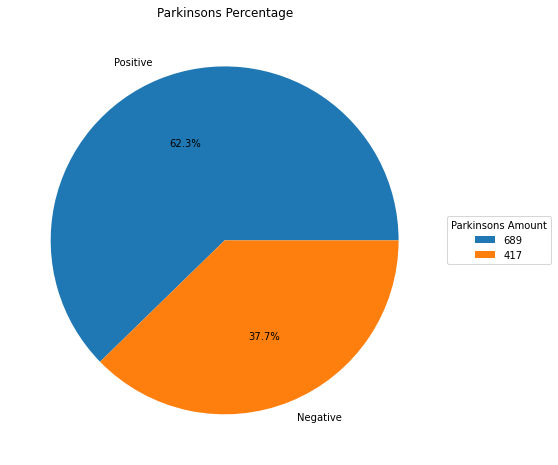

In [19]:
total_rows = complete_df.shape
counts_parkinson = complete_df[complete_df["Parkinsons"] == 1].shape

x = np.array([counts_parkinson[0], total_rows[0]-counts_parkinson[0]])
label = ["Positive", "Negative"]
plt.figure(figsize=(8,8), facecolor = "white")

plt.pie(x, labels = label, autopct='%1.1f%%')
plt.title("Parkinsons Percentage")
plt.legend(x, title="Parkinsons Amount", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [59]:

# # all_userdata_df.hist(bins = 10, figsize = (20,15), range = [0, 500])
# fig, axs = plt.subplots(1, 5, figsize = (30,5))

# axs[2].hist(all_userdata_df.Hold)
# axs[2].set_title('Hold')
# axs[3].hist(all_userdata_df.Latency)
# axs[3].set_title('Latency')
# axs[1].hist(all_userdata_df.Gender, color = "red")
# axs[1].set_title('Gender')
# axs[0].hist(all_userdata_df.Age)
# axs[0].set_title('Age')
# axs[4].hist(all_userdata_df.Parkinsons, color = "red")
# axs[4].set_title('Parkinsons')

# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==812648.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==84773.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==4480.5].index, inplace=True)

# # find = all_userdata_df[all_userdata_df.Hold > 3000]
# # print(find)
complete_df.set_index('Users', inplace = True)

complete_df.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930,406.716242,...,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771,58,0,0
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952,528.670445,...,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816,81,1,0
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168,358.358252,...,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478,74,0,1


In [24]:



x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values

print(x)
print(y)

# ho diviso tutte le colonne (x) dal target parkinsons (y)

[[ 96.96438356 108.92666667  26.59593938 ...  -0.63837867  58.
    0.        ]
 [ 80.53076923  86.25416667  18.0255767  ...   0.43694861  58.
    0.        ]
 [ 90.33103448  91.76470588  18.89323313 ...  -0.94149811  58.
    0.        ]
 ...
 [113.83947368  95.09512195  62.07531911 ...   3.34768528  61.
    0.        ]
 [130.48        95.91122449  64.75979571 ...   1.41287337  61.
    0.        ]
 [118.86018519  98.46825397  67.29287632 ...   5.52687006  61.
    0.        ]]
[0 0 0 ... 0 0 0]


In [25]:

# splitto matrice x e array y in sottoinsiemi random di train e test, di dimensioni 4/5 e 1/5
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

# graph = all_userdata_df.sample(n = 100)
# x_graph = graph.iloc[:, 1:3].values
# y_graph = graph.iloc[:, -1].values

# print(x_train)
# print(y_train)

# print(x_test)
# print(y_test)

# print(x_graph)
# print(y_graph)


In [41]:
# import collections
# print(len(y_train))
# new_parkinson = collections.Counter(y_train)[1]
# print(new_parkinson)


In [26]:
# prima del modello di classificazione faccio lo scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_graph = scaler.fit_transform(x_graph)
#proviamo con questo scaler dopo possiamo provare quello normaliza
# len(x_train) 
# len(x_test) = 316643
# len(x_graph) = 100

In [43]:
# matrice di correlazione per curiosita

# import seaborn as sns
# corr = pd.concat([x, y], axis=1).corr()
# corr_values = corr.iloc[:,15].values
# print("Massima correlazione positiva con il target:", np.max(corr_values[0:corr_values.size-1]))
# print("Massima correlazione negativa con il target:", np.min(corr_values))
# print(pd.concat([x, y], axis=1).columns[abs(corr_values) < 0.01]) 

# plt.figure(figsize=(15, 16), dpi=160)
# sns.heatmap(pd.concat([x, y], axis=1).corr(), cmap="bwr")


In [71]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=5, n_jobs=-1)

x_train, y_train = smote.fit_resample(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_train)

(46, 29) (46,)
[[-1.16168938 -1.12049658 -1.15256301 ... -0.67252389  1.24464308
  -1.        ]
 [-0.84904277 -0.9225224   0.01031104 ... -0.33113187 -1.61071457
  -1.        ]
 [-1.01002927 -1.13072764 -0.9518999  ... -1.42988381 -2.56250045
   1.        ]
 ...
 [ 1.10836123  1.29320459  1.25044323 ...  0.08076568  0.00951697
  -0.7400243 ]
 [ 0.26260976  0.06832358 -0.1380387  ... -0.38701393  0.65110147
   1.        ]
 [ 1.49855819  0.79261786  1.73973262 ... -0.33862418 -0.85101081
  -0.59831713]]


[0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1
 1 1 1 1 1 1 1 1 1]


(array([23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 23.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

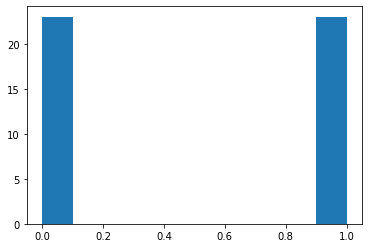

In [81]:
print(y_train)
np.histogram(y_train)
plt.hist(y_train)

0.916767189384801
0.9350180505415162


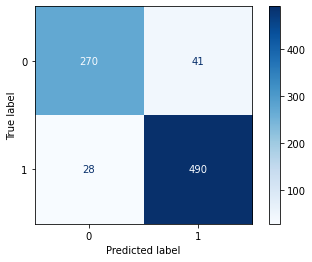

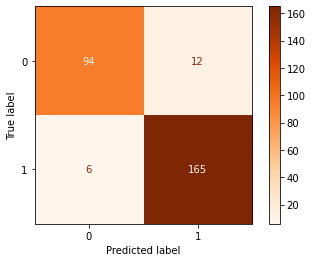

In [27]:
# Naive Bayes classification
classifierBAYES = GaussianNB()
classifierBAYES.fit(x_train, y_train)

y_pred_BAYES0 = classifierBAYES.predict(x_train)
y_pred_BAYES = classifierBAYES.predict(x_test)

CM_BAYES0 = confusion_matrix(y_train, y_pred_BAYES0)
PercBAYES0 = (CM_BAYES0[0,0]+CM_BAYES0[1,1])/CM_BAYES0.sum()

CM_BAYES = confusion_matrix(y_test, y_pred_BAYES)
PercBAYES = (CM_BAYES[0,0]+CM_BAYES[1,1])/CM_BAYES.sum()

cmd0 = ConfusionMatrixDisplay(CM_BAYES0)
cmd = ConfusionMatrixDisplay(CM_BAYES)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercBAYES0)
print(PercBAYES)



0.9601930036188179
0.9819494584837545


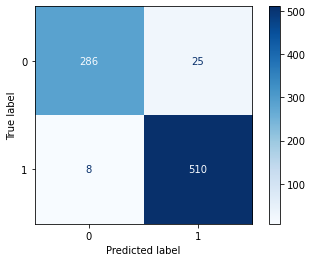

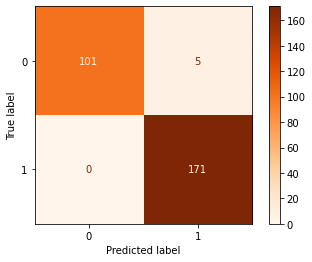

In [28]:

# qua si parte con il learning
# pero il ragazzo di Genova dice che x_train e x_test hanno troppe righe
# allora si riduce le dimensioni del dataset prendendo il 4% (applica test_size = 0.2 per due volte)

#############


classifierLogReg = LogisticRegression(random_state = 0)
classifierLogReg.fit(x_train, y_train)

#The algorithm has learnt on training set, now I will predict the outcomes on test set
y_pred_LogReg0 = classifierLogReg.predict(x_train)
y_pred_LogReg = classifierLogReg.predict(x_test)

# ogni riga e un'istanza della classe vera
# e la matrice TP FP TN FN
CM_LogReg0 = confusion_matrix(y_train, y_pred_LogReg0)
PercLogReg0 = (CM_LogReg0[0,0]+CM_LogReg0[1,1])/CM_LogReg0.sum()

CM_LogReg = confusion_matrix(y_test, y_pred_LogReg)
PercLogReg = (CM_LogReg[0,0]+CM_LogReg[1,1])/CM_LogReg.sum()
# print(CM_LogReg)
# print(CM_LogReg0)

# print(PercLogReg)
# print(PercLogReg0)

cmd0 = ConfusionMatrixDisplay(CM_LogReg0)
cmd = ConfusionMatrixDisplay(CM_LogReg)

cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercLogReg0)
print(PercLogReg)

#visual
# from matplotlib.colors import ListedColormap

# classifierLogReg_graph = LogisticRegression(random_state = 0)
# classifierLogReg_graph.fit(x_graph, y_graph)

# X_set, y_set = x_graph, y_graph
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                      np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
# plt.figure(1)
# plt.contourf(X1, X2, classifierLogReg_graph.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#                 c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Logistic Regression')
# plt.xlabel('Latency')
# plt.ylabel('Hold')
# plt.legend()
# plt.show()




1.0
1.0


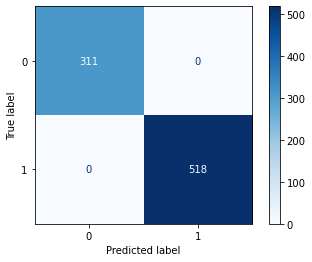

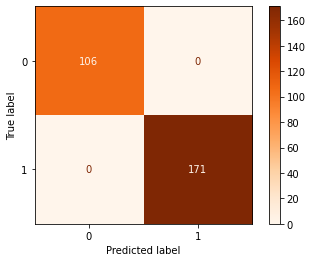

In [29]:
# Decision Tree classification

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

# provare la profondita e capire perche

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)


1.0
0.9891696750902527


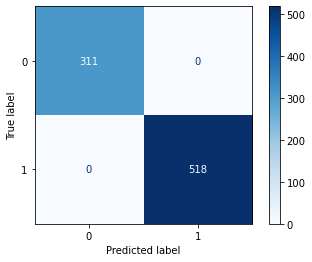

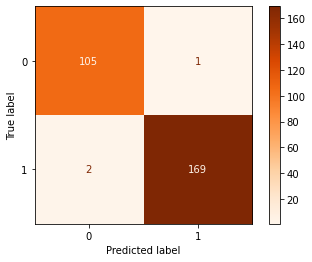

In [30]:
# Random Forest classification

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

In [48]:
# metric = 'recall'
# n_folds = 5
# scores_dict = {}


In [52]:
# DIMINUIRE LA CARDINALITA DEL DATASET
#x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.2)
#x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.2)

0.8299867043943682
0.8358331060812654


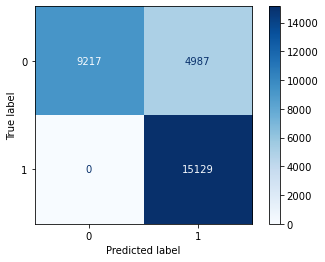

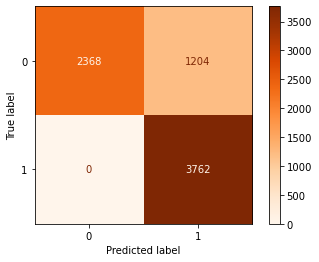

In [50]:
# Decision Tree classification
# rifaccio dopo il taglio

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

# provare la profondita e capire perche

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)


0.9869771247400538
0.9196891191709845


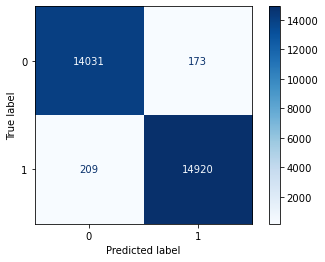

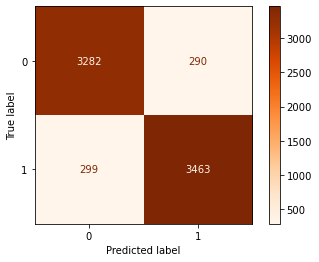

In [51]:
# Random Forest classification
# rifaccio dopo il taglio

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

0.782608695652174
0.75


c:\Users\tagli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


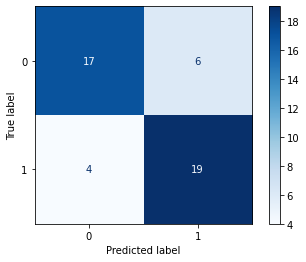

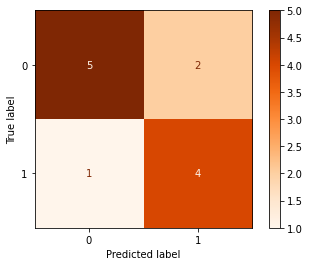

In [86]:
# altri metodi : chi piu ne ha piu ne metta

# Multiple Layer Perceptron
# -------------------------------------------------------------------


classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "relu", max_iter=50) # relu act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "tanh", max_iter=50) # tanh act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "identity", max_iter=50) # identity act LUI FA CAGARE ATTENZIONE
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "logistic", max_iter=50) # logistic act


classifierMLPr.fit(x_train, y_train)

y_pred_MLPr0 = classifierMLPr.predict(x_train)
y_pred_MLPr = classifierMLPr.predict(x_test)

CM_MLPr0 = confusion_matrix(y_train, y_pred_MLPr0)
PercMLPr0 = (CM_MLPr0[0,0] + CM_MLPr0[1,1])/CM_MLPr0.sum()

CM_MLPr = confusion_matrix(y_test, y_pred_MLPr)
PercMLPr = (CM_MLPr[0,0] + CM_MLPr[1,1])/CM_MLPr.sum()

cmd0 = ConfusionMatrixDisplay(CM_MLPr0)
cmd = ConfusionMatrixDisplay(CM_MLPr)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercMLPr0)
print(PercMLPr)

In [87]:
# ADABOOST v1


classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [.001, .01, .1, 1]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(x_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773333 using {'learning_rate': 0.001, 'n_estimators': 200}
0.773333 (0.193103) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.771667 (0.213574) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.705000 (0.188569) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.735000 (0.180808) with: {'learning_rate': 1, 'n_estimators': 200}


1.0
0.5


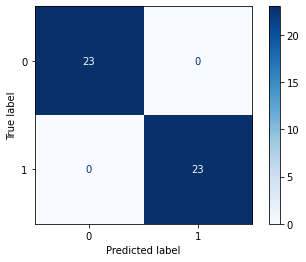

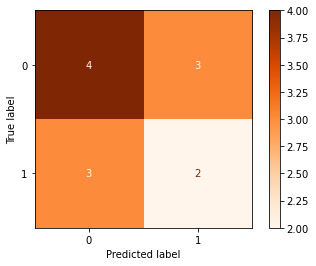

In [88]:
# ADABOOST v2


classifierAB = AdaBoostClassifier()
classifierAB.fit(x_train, y_train)

y_pred_AB0 = classifierAB.predict(x_train)
y_pred_AB = classifierAB.predict(x_test)

CM_AB0 = confusion_matrix(y_train, y_pred_AB0)
PercAB0 = (CM_AB0[0,0] + CM_AB0[1,1])/CM_AB0.sum()

CM_AB = confusion_matrix(y_test, y_pred_AB)
PercAB = (CM_AB[0,0] + CM_AB[1,1])/CM_AB.sum()

cmd0 = ConfusionMatrixDisplay(CM_AB0)
cmd = ConfusionMatrixDisplay(CM_AB)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercAB0)
print(PercAB)

0.9130434782608695
0.6666666666666666


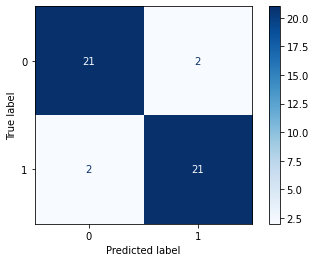

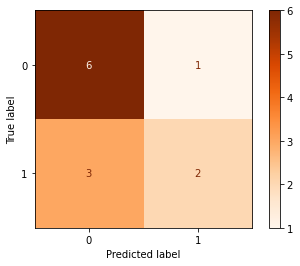

In [89]:
# SVM to fit algorithm

classifierSVC = SVC(kernel = 'rbf', random_state = 0)
classifierSVC.fit(x_train, y_train)

y_pred_SVMK0 = classifierSVC.predict(x_train)
y_pred_SVMK = classifierSVC.predict(x_test)

CM_SVMK0 = confusion_matrix(y_train, y_pred_SVMK0)
PercSVMK0 = (CM_SVMK0[0,0]+CM_SVMK0[1,1])/CM_SVMK0.sum()

CM_SVMK = confusion_matrix(y_test, y_pred_SVMK)
PercSVMK = (CM_SVMK[0,0]+CM_SVMK[1,1])/CM_SVMK.sum()

cmd0 = ConfusionMatrixDisplay(CM_SVMK0)
cmd = ConfusionMatrixDisplay(CM_SVMK)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercSVMK0)
print(PercSVMK)

0.782608695652174
0.6666666666666666


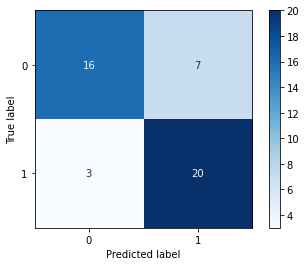

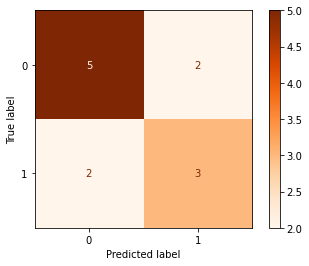

In [90]:
# KNN to fit algorithm

classifierKNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierKNN.fit(x_train, y_train)

y_pred_KNN0 = classifierKNN.predict(x_train)
y_pred_KNN = classifierKNN.predict(x_test)

CM_KNN0 = confusion_matrix(y_train, y_pred_KNN0)
PercKNN0 = (CM_KNN0[0,0]+CM_KNN0[1,1])/CM_KNN0.sum()

CM_KNN = confusion_matrix(y_test, y_pred_KNN)
PercKNN = (CM_KNN[0,0]+CM_KNN[1,1])/CM_KNN.sum()

cmd0 = ConfusionMatrixDisplay(CM_KNN0)
cmd = ConfusionMatrixDisplay(CM_KNN)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercKNN0)
print(PercKNN)

0.9130434782608695
0.75


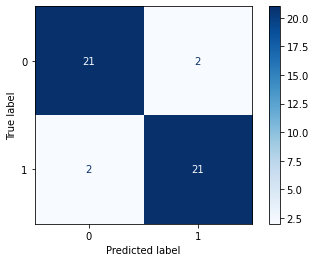

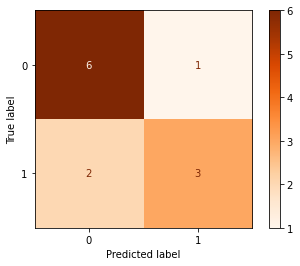

In [91]:
# Ensemble voting

Models = []
Models.append(('KNN', classifierKNN))
Models.append(('SVC', classifierSVC))
Models.append(('Tree', classifierTREE))
# Models.append(('Logistic', classifierLogReg))
# Models.append(('Bayes', classifierBAYES))
# by removing these last two classifiers, performances increase

ensemble = VotingClassifier(Models)
ensemble = ensemble.fit(x_train, y_train)

y_pred_ENS0 = ensemble.predict(x_train)
y_pred_ENS = ensemble.predict(x_test)

CM_ENS0 = confusion_matrix(y_train, y_pred_ENS0)
PercENS0 = (CM_ENS0[0,0]+CM_ENS0[1,1])/CM_ENS0.sum()

CM_ENS = confusion_matrix(y_test, y_pred_ENS)
PercENS = (CM_ENS[0,0]+CM_ENS[1,1])/CM_ENS.sum()

cmd0 = ConfusionMatrixDisplay(CM_ENS0)
cmd = ConfusionMatrixDisplay(CM_ENS)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercENS0)
print(PercENS)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


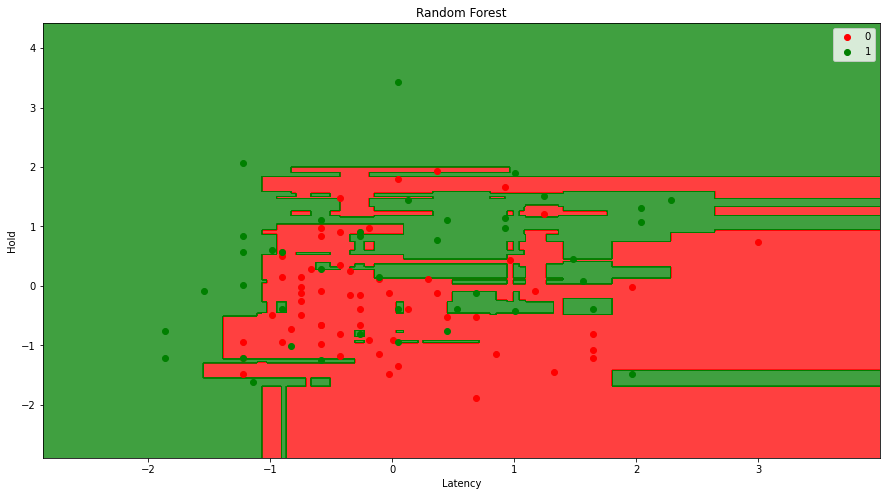

In [66]:
# Grafico Random Forest (visualizzazione)

from matplotlib.colors import ListedColormap

classifierFOR_graph = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR_graph.fit(x_graph, y_graph)

X_set, y_set = x_graph, y_graph
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.figure(4, figsize = (15, 8))
plt.contourf(X1, X2, classifierFOR_graph.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Random Forest')
plt.xlabel('Latency')
plt.ylabel('Hold')
plt.legend()
plt.show()